In [6]:
!pip install torch
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [76]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, base_regression_pipeline, regression_accuracy, threshold_accuracy, load_model, drop_helpers

# Data manipulation 
import pandas as pd
import numpy as np
import time
import math
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [77]:
# Load Data
data = PricingWizardDataset()

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


In [78]:
# Apply data preparation
print('Applying data preparation...')
data.apply_function(base_regression_pipeline)
print('Done.')

Applying data preparation...
Done.


In [79]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


## Load Model

In [19]:
# Current working directory
cwd = os.getcwd()

# model directory
model_dir = os.path.join(cwd, 'models', 'pickled_models')

linear_svr = load_model(f'{model_dir}/prediction_svr_linear.pkl')

Model loaded successfully from /Users/albertobfilho/Repositories/data-mining/pricing_wizards/models/pickled_models/prediction_svr_linear.pkl
LinearSVR(C=0.1, dual='auto', epsilon=0.5)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LinearSVR from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Linear SVR - Base pipeline

In [81]:
# StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(drop_helpers(data.X_train))
X_test_scaled = scaler.fit_transform(drop_helpers(data.X_test))

In [82]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(linear_svr, X_train_scaled, data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_linear: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
linear_svr.fit(X_train_scaled, data.y_train)
end_time = time.time()

# Calculate training time
training_time_linear = end_time - start_time

# Evaluate the final model on the test set
y_pred_test_base = linear_svr.predict(X_test_scaled)
y_test_base = data.y_test

regression_accuracy(y_pred_test_base, y_test_base)
print("Cross-validation Score:", mse_mean_cv_linear)
print("Training Time:", training_time_linear)

R2 Score: 0.545131355778
MSE: 0.43825602328401725
MAE 0.5130068235024128
RMSE 0.6620090809679405
Cross-validation Score: 0.4411990409758668
Training Time: 0.7334930896759033


In [90]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(linear_svr, X_test_scaled, y_test_base, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,brand_name,0.639408
2,subsubsubcategory_name,0.130220
1,condition_name,0.058474


In [91]:
# Feature importance based on regressor coefficients
model_coef = linear_svr.coef_
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Coef': model_coef})
feature_importance.sort_values(by='Coef', ascending=False)

,Feature,Coef
0,brand_name,0.560604
2,subsubsubcategory_name,0.256013
1,condition_name,0.170221


In [92]:
data.reset_dataset()

## SVR RBF - Base pipeline

In [18]:
# Define regressor
rbf_svr = SVR(kernel="rbf")

In [ ]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(rbf_svr, data.X_train, data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_rbf: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
rbf_svr.fit(data.X_train, data.y_train)
end_time = time.time()

# Calculate training time
training_time_rbf = end_time - start_time

# Evaluate the final model on the test set
y_pred_test_base = rbf_svr.predict(data.X_test)
y_test_base = data.y_test

regression_accuracy(y_pred_test_base, y_test_base)
print("Cross-validation Score:", mse_mean_cv_rbf)
print("Training Time:", training_time_rbf)

In [ ]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(rbf_svr, X_test, y_test, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

In [ ]:
# Feature importance based on regressor coefficients
model_coef = rbf_svr.coef_
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Coef': model_coef})
feature_importance.sort_values(by='Coef', ascending=False)

In [41]:
data.reset_dataset()

## Linear SVR - OHE

In [93]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


In [94]:
# Identify categorical columns
numeric_columns = drop_helpers(data.X_train).select_dtypes(include=['number']).columns
categorical_columns = drop_helpers(data.X_train).select_dtypes(include=['object']).columns

# Create a ColumnTransformer to apply OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Create a pipeline with preprocessing and Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', linear_svr)
])

cv_scores: list = cross_val_score(pipeline, drop_helpers(data.X_train), data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv: float = -np.mean(cv_scores)

# Fit the pipeline on the training data
pipeline.fit(drop_helpers(data.X_train), data.y_train)

# Evaluate the final model on the test set
y_pred_test_ohe = pipeline.predict(drop_helpers(data.X_test))

# Evaluate the model
y_test_ohe = data.y_test
regression_accuracy(y_pred_test_ohe, y_test_ohe)
print("Cross-validation Score:", mse_mean_cv)

R2 Score: 0.7691340381768607
MSE: 0.22243432170028493
MAE 0.3404073335335832
RMSE 0.4716294326060291
Cross-validation Score: 0.22054593066182618


In [96]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(pipeline, drop_helpers(data.X_test), y_test_ohe, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
5,brand_name,0.152731
11,subsubsubcategory_name,0.067068
15,classified_price_normalized,0.065279
2,classified_price,0.065279
12,classified_price_standardized,0.065279
18,log_viewed_count,0.041445
6,condition_name,0.023101
10,subsubcategory_name,0.011986
8,category_name,0.005716
9,subcategory_name,0.002775


## Visualizations

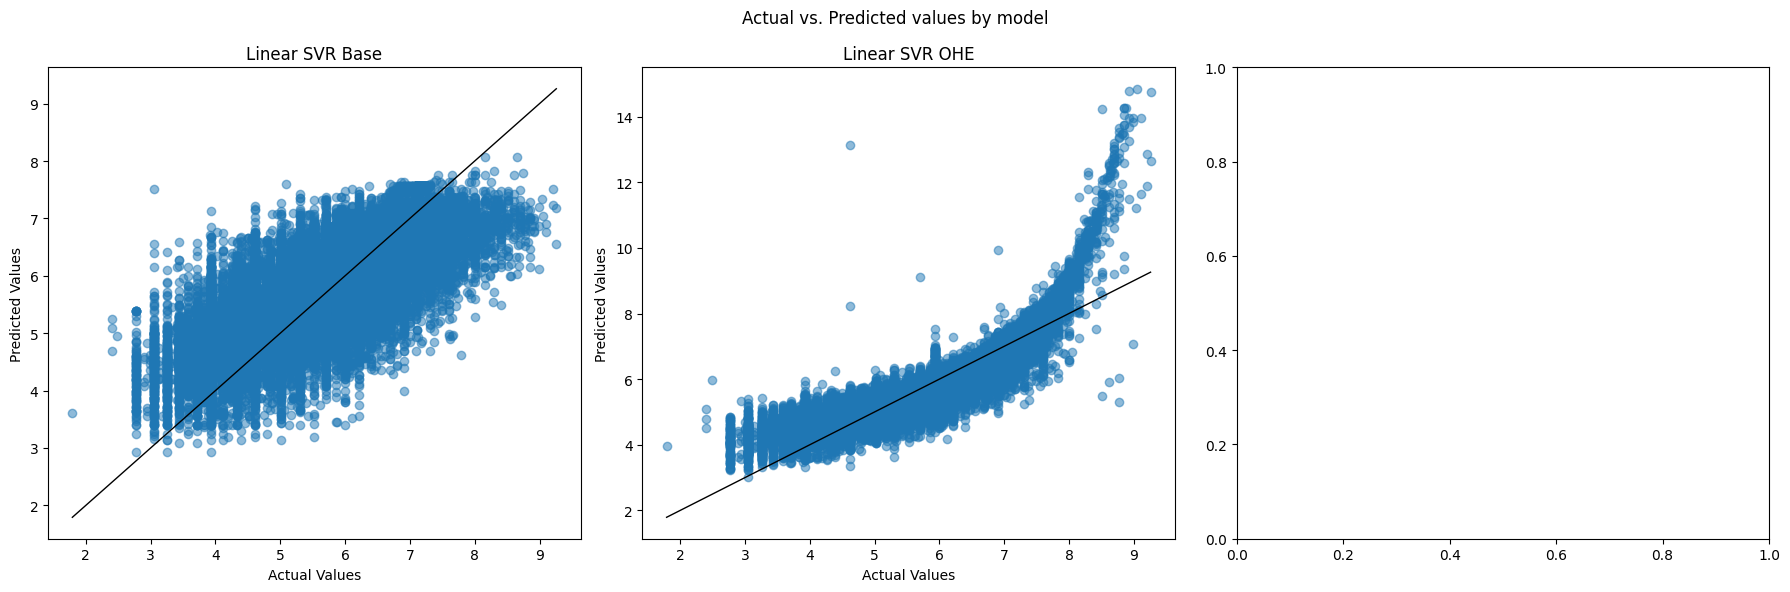

In [119]:
# actual vs predicted
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe, y_test_ohe)]
labels= ["Linear SVR Base", "Linear SVR OHE", "SVR poly"]

num_models = len(pipelines)
num_cols = 3
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, (y_pred, y_test) in enumerate(pipelines):
    axs[i].scatter(y_test, y_pred, alpha=0.5)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k', lw=1)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Actual Values')
    axs[i].set_ylabel('Predicted Values')

plt.suptitle("Actual vs. Predicted values by model")

plt.show(fig)

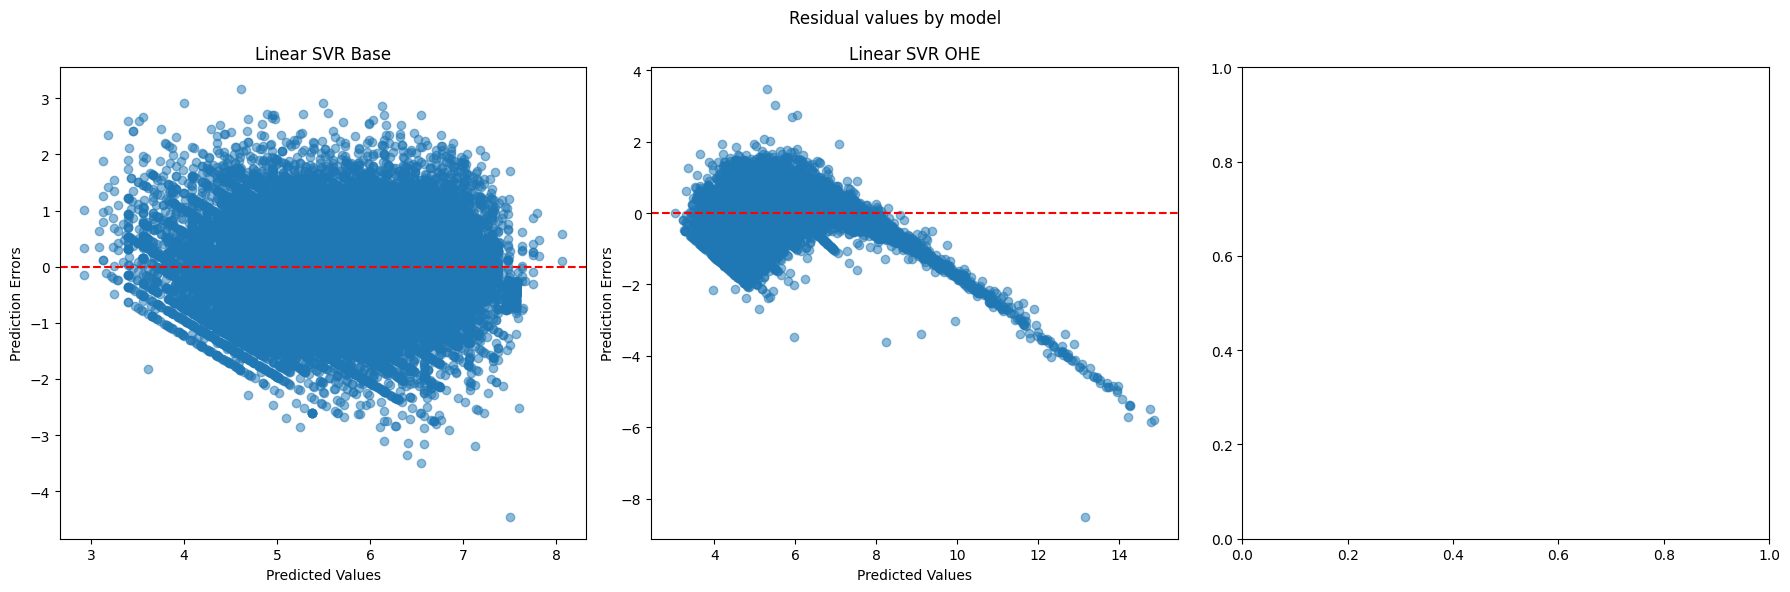

In [120]:
# residuals
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe, y_test_ohe)]
labels= ["Linear SVR Base", "Linear SVR OHE", "SVR poly"]

num_models = len(models)
num_cols = 3
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, (y_pred, y_test) in enumerate(pipelines):
    # Calculate residuals
    prediction_error = y_test - y_pred

    # Plot the scatter plot on the specific subplot
    axs[i].scatter(y_pred, prediction_error, alpha=0.5)
    axs[i].axhline(y=0, color='r', linestyle='--')
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Predicted Values')
    axs[i].set_ylabel('Prediction Errors')

plt.suptitle("Residual values by model")

plt.show(fig)

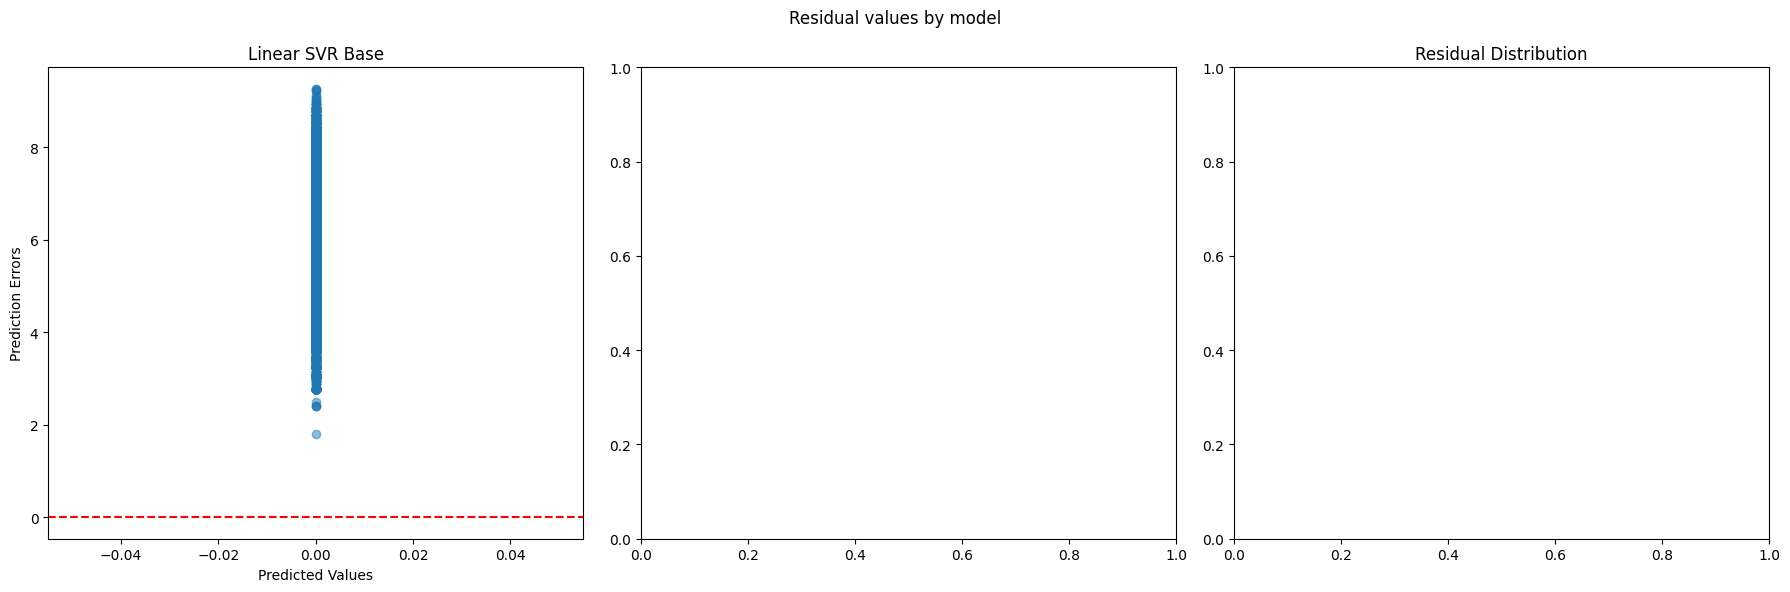

In [117]:
# residuals
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe, y_test_ohe)]
labels= ["Linear SVR Base", "Linear SVR OHE", "SVR poly"]

num_models = len(models)
num_cols = 3
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, model in enumerate(models):
    # Calculate residuals
    prediction_error = y_test - y_pred_test

    # Plot the scatter plot on the specific subplot
    axs[i].scatter(y_pred_test, prediction_error, alpha=0.5)
    axs[i].axhline(y=0, color='r', linestyle='--')
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Predicted Values')
    axs[i].set_ylabel('Prediction Errors')

plt.suptitle("Residual values by model")

plt.title('Residual Distribution')
plt.show()

In [ ]:
# model evaluation
regressor_names = [result.label for results in results.values() for result in results]

mse_mean_cv_values = [result.mse_mean_cv for results in results.values() for result in results]
mse_test_values = [result.mse_test for results in results.values() for result in results]

bar_width = 0.35
index = range(len(regressor_names))

fig, ax = plt.subplots(tight_layout=True)
bar1 = ax.bar(index, mse_mean_cv_values, bar_width, label='MSE Mean CV')
bar2 = ax.bar([i + bar_width for i in index], mse_test_values, bar_width, label='MSE Test')

ax.set_xlabel('Regressor')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE Mean CV and MSE Test for Each Regressor')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(regressor_names)
ax.legend()

plt.show(fig)

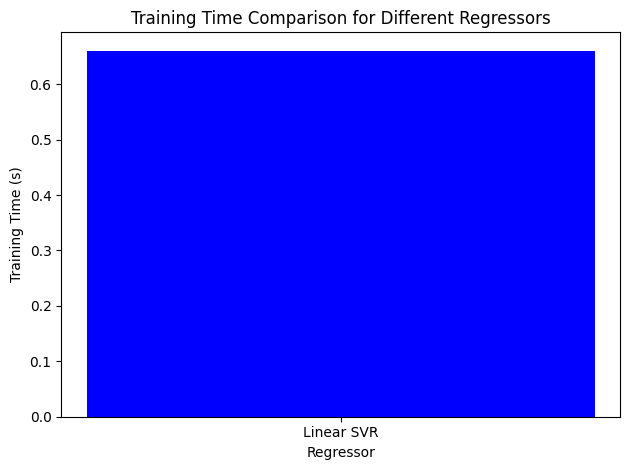

In [95]:
regressor_names = ["Linear SVR"]
training_times = [training_time_linear]

fig, ax = plt.subplots(tight_layout=True)
ax.bar(regressor_names, training_times, color='blue')
ax.set_xlabel('Regressor')
ax.set_ylabel('Training Time (s)')
ax.set_title('Training Time Comparison for Different Regressors')

plt.show(fig)